In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as datasets
import torchvision.utils as vutils

import os
import json
import numpy as np
import csv
import pandas as pd
import math
import numpy as np
import glob
import tqdm
import sys
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from tqdm import tqdm

import seaborn as sns
sns.set_theme(style="ticks")

import torchvision
from torchvision.io import read_image

sys.path.insert(0, '/home/sharifullina/thesis/Soft-DTW-Loss/')
from sdtw_cuda_loss import SoftDTW

import time_series_metric


In [44]:
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [45]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [46]:
# target_folder = './extracted/mwd/nopims/'
target_folder = '/home/sharifullina/thesis/datasets/extracted/mwd/volve/'
# target_folder = '/home/sharifullina/thesis/datasets/extracted/well_logs/volve/'
# target_folder = '/home/sharifullina/thesis/datasets/extracted/well_logs/nopims/'

In [47]:
wells = os.listdir(target_folder)
len(wells)

23

In [48]:
logs = [json.load(open(os.path.join(target_folder, wells[i]), 'r')) for i in range(len(wells))]

In [31]:
# required_params_well_log = ['DEPTH', 'A40H', 'GR', 'RHOB', 'TNPH']

In [50]:
# dataset_all_well_log = [pd.DataFrame(logs[i]['data'], columns=[x['name'] for x in logs[i]['curves']]) for i in range(len(logs))]
# dataset = []
# for df in dataset_all_well_log:
#     dataset.append(df[required_params_well_log] if df[i].isna().any() for i in required_params_well_log)

In [51]:
required_params_mwd = ['DEPTH', 'ROPA', 'HKLA', 'WOB', 'SPPA']

In [52]:
# соеденим все логи скважин в один большой pandas.DaraFrame
dataset_all = [pd.DataFrame(logs[i]['data'], columns=[x['name'] for x in logs[i]['curves']]) for i in range(len(logs))]
dataset = []
for df in dataset_all:
    dataset.append(df[required_params_mwd])
X_all = dataset[0]
for i in range(1, len(dataset)):
    X_all = pd.concat([X_all, dataset[i]], ignore_index = True)


In [53]:
X_all = X_all.dropna(axis=0)

In [55]:
# в эти два списка запишем по 20 датафреймов схожих и различающихся скважин с размером окна 256
similar_wells = []

for i in range(0, 18400, 20):
    similar_wells.append(X_all[i : 256 + i])
    
# преобразуем лист в массив с размерностью [20, 256, 5]; 920 - количество скважин, 256 - размерность окна, 
#                                                   5 - количество столбцов = len(required_params_mwd)
similar_wells = np.dstack(similar_wells)
similar_wells = np.rollaxis(similar_wells, -1)


In [56]:
different_wells = []

for i in range(0, 256 * 230, 256):
    different_wells.append(X_all[i : 256 + i])
    different_wells.append(X_all[i : 256 + i] + np.random.normal(X_all[i : 256 + i].mean(),\
                                                                 X_all[i : 256 + i].std(), [256, 5]))
    different_wells.append(X_all[i : 256 + i] + np.random.normal(X_all[i : 256 + i].mean(), \
                                                                 X_all[i : 256 + i].std(), [256, 5]))
    different_wells.append(X_all[i : 256 + i] + np.random.normal(X_all[i : 256 + i].mean(),\
                                                                 X_all[i : 256 + i].std(), [256, 5]))
    
different_wells = np.dstack(different_wells)
different_wells = np.rollaxis(different_wells, -1)

In [57]:
from time_series_metric.all_metrics import *
needed_actions = [f for f in time_series_metric.all_metrics.__dict__.values()
                   if hasattr(f,'__call__')]

In [58]:
needed_actions

[<function time_series_metric.all_metrics.mean_similarity(x, y)>,
 <function time_series_metric.all_metrics.root_mean_square_similarity(x, y)>,
 <function time_series_metric.all_metrics.coisine_between_angles(x, y)>,
 <function time_series_metric.all_metrics.pearson_corr_funct(x, y)>,
 <function time_series_metric.all_metrics.eucledian_distance(x, y)>]

In [59]:
# ключами словаря similar_metric будут названия функций
# элементами ключей будут значения функций для каждой из 20 скважин для каждого элемента из 5 элеметов списка required_params
# т.е. [[shape=20], [shape=20], [shape=20], [shape=20], [shape=20]]

similar_metric = {}

for k in range(len(needed_actions)):
    if str(needed_actions[k]) not in similar_metric:
        similar_metric[str(needed_actions[k])] = []
        
        
one_req_param = []
for k in range(len(needed_actions)):
    for i in range(len(required_params_mwd)):
        for j in range(1, similar_wells.shape[0]):
            one_req_param.append(needed_actions[k].__call__(similar_wells[j - 1][:, i], similar_wells[j][:, i]))
        similar_metric[str(needed_actions[k])].append(one_req_param)
        one_req_param = []

In [60]:
different_metric = {}

for k in range(len(needed_actions)):
    if str(needed_actions[k]) not in different_metric:
        different_metric[str(needed_actions[k])] = []

one_req_param = []
for k in range(len(needed_actions)):
    for i in range(len(required_params_mwd)):
        for j in range(1, different_wells.shape[0]):
            one_req_param.append(needed_actions[k].__call__(different_wells[j - 1][:, i], different_wells[j][:, i]))
        different_metric[str(needed_actions[k])].append(one_req_param)
        one_req_param = []

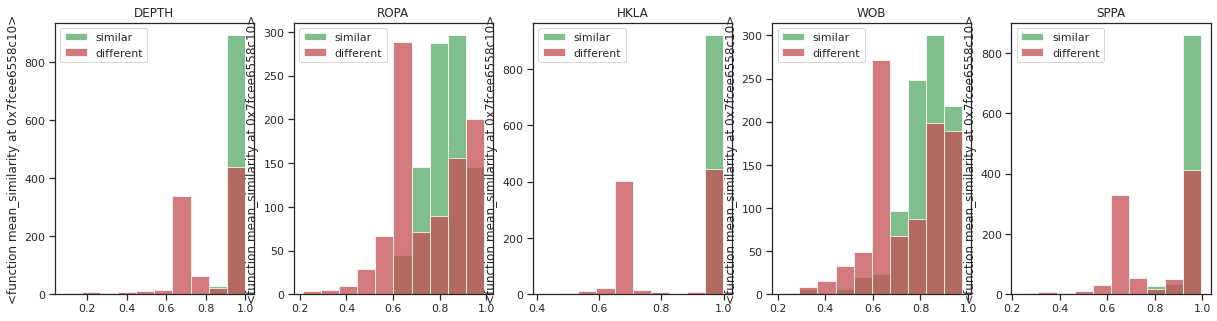

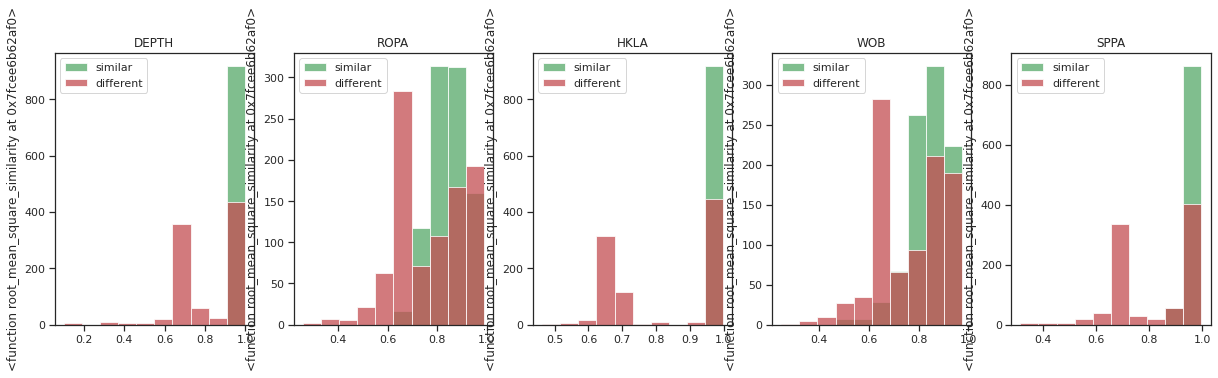

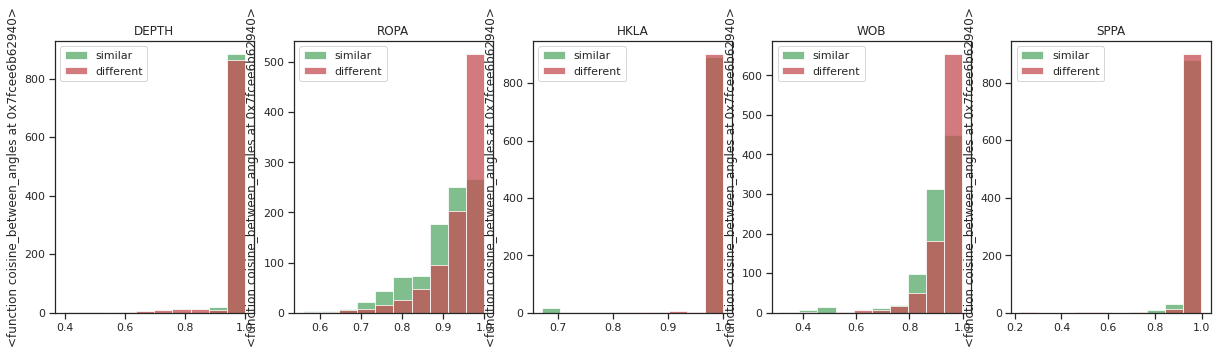

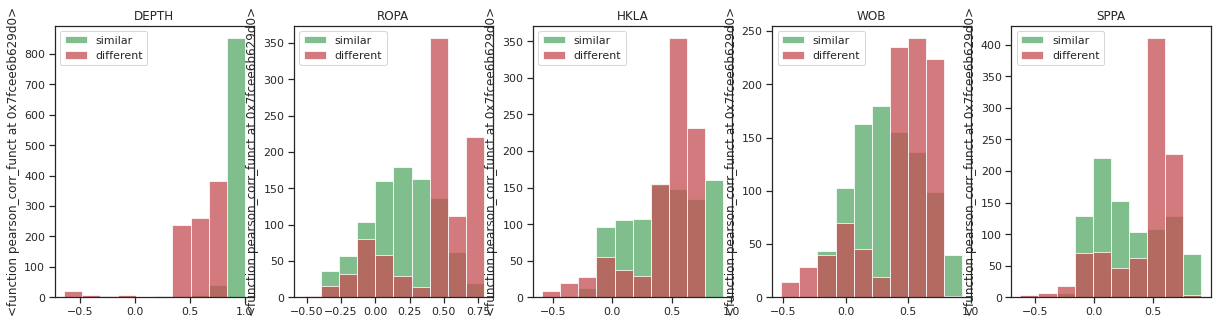

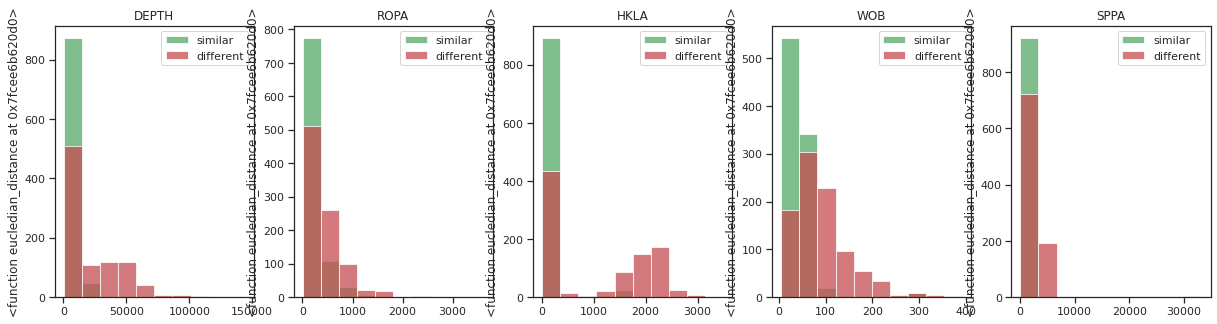

In [61]:
import scipy.stats as stats


for j in range(len(similar_metric)):
    plt.figure(figsize=(25, 5))
    for i in range(1, 6):
        plt.subplot(1, 6, i)
        plt.title(required_params_mwd[i - 1])
        
        plt.hist(similar_metric[str(needed_actions[j])][i - 1], \
                 bins = 10, range=[min(min(similar_metric[str(needed_actions[j])][i - 1]), min(different_metric[str(needed_actions[j])][i - 1])), \
                                   max(max(similar_metric[str(needed_actions[j])][i - 1]), max(different_metric[str(needed_actions[j])][i - 1]))],\
                 facecolor='g', alpha=0.75, label = 'similar')
        
        plt.hist(different_metric[str(needed_actions[j])][i - 1],\
                 bins = 10, range=[min(min(similar_metric[str(needed_actions[j])][i - 1]), min(different_metric[str(needed_actions[j])][i - 1])),\
                                   max(max(similar_metric[str(needed_actions[j])][i - 1]), max(different_metric[str(needed_actions[j])][i - 1]))],\
                 facecolor='r', alpha=0.75, label = 'different')
        
        plt.legend()
        plt.ylabel(str(needed_actions[j]))
        
        
plt.show()      